In this example, the dataset is generated and a frame of the manual labels and automatically generated labels is plotted.

In [54]:
import os
import sys
parent_directory = os.path.abspath('..')
sys.path.append(parent_directory)
import matplotlib.pyplot as plt
import json
import numpy as np
from data_preparation import data_preparation

This function is used to convert a cube cloud to a point cloud and assign the corresponding color.

In [55]:
def lidarcube_to_pc_gt(cube, params):
    if params is None:
        params = data_preparation.get_default_params()
    range_axis = params['range_axis']
    azimuth_axis = params['azimuth_axis']
    elevation_axis = params['elevation_axis']
    label = []
    cube_useful = np.squeeze(cube)
    nonzero_indices = np.nonzero(cube_useful)
    nonzero_indices = np.array(nonzero_indices)
    for i in range(np.size(nonzero_indices,1)):
        x = nonzero_indices[1][i]
        y = nonzero_indices[2][i]
        z = nonzero_indices[0][i]
        classes = cube[z,x,y]
        if classes == 1:
            label.append([70,70,70])
        elif classes == 2:
            label.append([220,20,60])
        elif classes == 3:
            label.append([0,0,142])
        elif classes == 4:
            label.append([119,11,32])
    label = np.array(label)
    range_values = range_axis[nonzero_indices[1, :]]
    azimuth_values = azimuth_axis[nonzero_indices[2, :]]
    elevation_values = elevation_axis[nonzero_indices[0, :] - 1]
    pc = data_preparation.spherical_to_cartesian(range_values, azimuth_values, elevation_values)
    return pc, label

Read the automatic labelling results and transform it to the point clouds format.

In [56]:
auto_cube =  np.load('data/001696857101.513507128.npy') # Change the path to the automatic labelling results
lidar_pc, auto_label = lidarcube_to_pc_gt(auto_cube,None)

Read the manual labelling results (save in json format).

In [57]:
result_dict = {}
result_dict = {'masks': [], 'class': []}
path_json = 'data/Manual.json' # Change the path to the manual labelling results
with open(path_json, 'r') as file:
    initial = json.load(file)
    objects = initial['objects']
    data = initial['figures']
    class_title = []
    class_id = []
    for obj in objects:
        class_title.append(obj['classTitle'])
        class_id.append(obj['id'])
    for k, figure in enumerate(data):
        mask = figure['geometry']['indices']
        objectid = figure['objectId']
        indices = np.where(np.array(class_id) == objectid)[0]
        if indices.size > 0:
            result_dict['masks'].append(mask)
            result_dict['class'].append(class_title[indices[0]])
    manual_label = np.full(auto_label.shape, 70)
    for j in range(len(result_dict['class'])):
        if result_dict['class'][j] == 'Pedestrain':
            new_color = [220,20,60]
        if result_dict['class'][j] == 'Vehicle':
            new_color = [0,0,142]
        if result_dict['class'][j] == 'Bicycle':
            new_color = [119,11,32]
        manual_label[result_dict['masks'][j]] = new_color

Process the point clouds, corresponding labels and then plot.

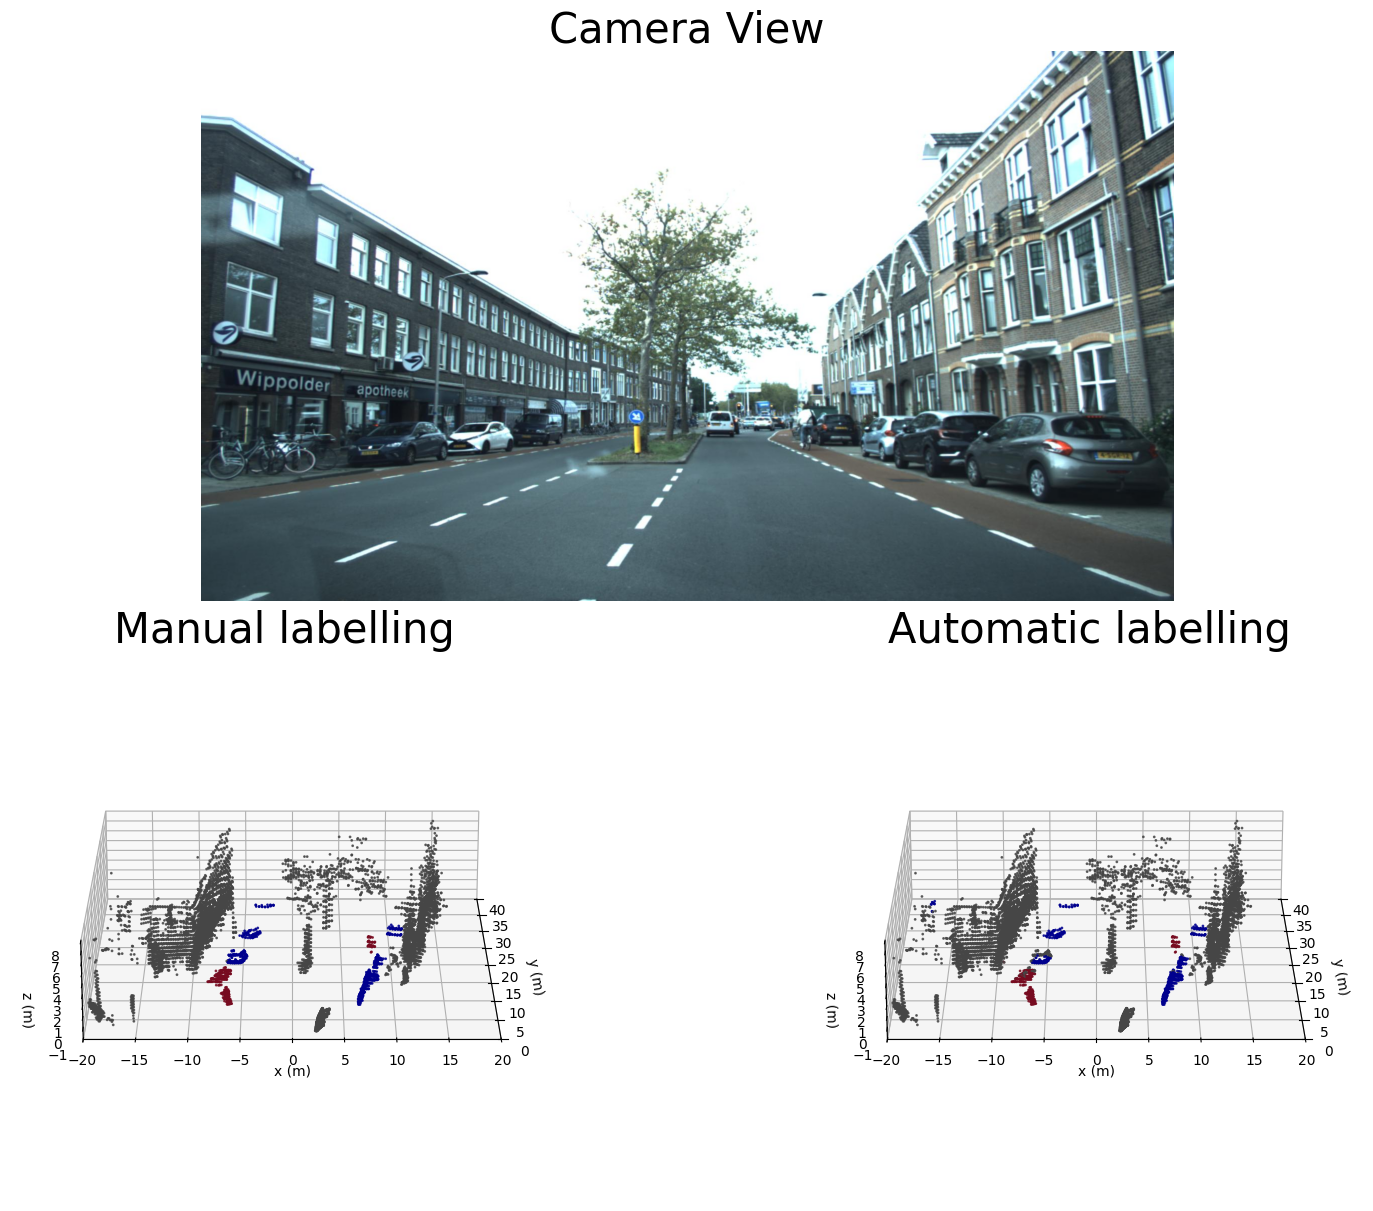

In [58]:
layout = [["camera", "camera"],
    ["manual", "auto"]
]
auto = auto_label[lidar_pc[:, 1] > -20,:]
manual = manual_label[lidar_pc[:, 1]>-20,:]
lidar_pc = lidar_pc[lidar_pc[:, 1]>-20,:]

auto = auto[lidar_pc[:, 1] <20,:]
manual = manual[lidar_pc[:, 1]<20,:]
lidar_pc = lidar_pc[lidar_pc[:, 1]<20,:]

auto = auto[lidar_pc[:, 2] <8,:]
manual = manual[lidar_pc[:, 2]<8,:]
lidar_pc = lidar_pc[lidar_pc[:, 2]<8,:]

auto = auto[lidar_pc[:, 2] > -2, :]
manual = manual[lidar_pc[:, 2] > -2, :]
lidar_pc = lidar_pc[lidar_pc[:, 2] > -2, :]


auto = auto[lidar_pc[:, 0] < 40, :]
manual = manual[lidar_pc[:, 0] < 40, :]
lidar_pc = lidar_pc[lidar_pc[:, 0] < 40, :]
auto = auto/255
manual = manual/255
fig, axd = plt.subplot_mosaic(layout, figsize=(16, 12), layout='constrained',
                              per_subplot_kw={('auto', 'manual'): {'projection': '3d'}},
                              gridspec_kw={'wspace': 0.01, 'hspace': 0.01},
                             )
radarplot = axd["auto"].scatter(lidar_pc[:, 0], -lidar_pc[:, 1],lidar_pc[:,2],c=auto,
                                alpha=0.8, s=1)

axd["auto"].view_init(elev=20, azim=0)
axd["auto"].set_ylim(-20, 20)
axd["auto"].set_zlim(-1, 8)
axd["auto"].set_xlim(0, 40)
axd["auto"].set_box_aspect([2, 2, 0.5])
axd["auto"].set_xlabel('y (m)')
axd["auto"].set_ylabel('x (m)')
axd["auto"].set_zlabel('z (m)')
axd["auto"].invert_xaxis()
axd["auto"].set_title('Automatic labelling',fontsize = 30)

lidarplot=axd["manual"].scatter(lidar_pc[:, 0], -lidar_pc[:, 1], lidar_pc[:, 2], c=manual, alpha=0.8, s=1)
axd["manual"].view_init(elev=20, azim=0)
axd["manual"].set_ylim(-20, 20)
axd["manual"].set_zlim(-1, 8)
axd["manual"].set_xlim(0, 40)
axd["manual"].set_box_aspect([2, 2, 0.5])
axd["manual"].set_xlabel('y (m)')
axd["manual"].set_ylabel('x (m)')
axd["manual"].set_zlabel('z (m)')
axd["manual"].invert_xaxis()
axd["manual"].set_title('Manual labelling',fontsize = 30)


img = plt.imread('data/001696857101.617000000.jpg')
axd["camera"].imshow(img, aspect='0.9')
axd["camera"].axis('off')
axd["camera"].set_title('Camera View',fontsize = 30)
plt.show()